# Machine Learning exercise 1: Credit Card Fraud Detection
2021 08 13  Maarten Pennings  Textual improvements  
2021 06 20  Maarten Pennings  Added "Random" seeds at the start of this notebook  
2021 06 12  Maarten Pennings  Created

I followed "Using Python to Implement a Complete Machine Learning Flow", a Doulos Webinar by John Aynsley.

With this notebook, I try to replicate John's first example.


## The project directory, with a Jupyter notebook
Somehow I got the impression the best way to follow John was to run the Python exercises in a _Jupyter notebook_.
I do not believe he mentioned that in the training, so I don't know where I got that from.

It is my first time for using Jupyter. I was surprised how simple that is; basically `pip install jupyter` if you already have Python.

I typically use a _virtual environment_ in my Python projects, and I use fixed structure to organize that.
There is a _project_ directory with two files `setup.bat` and `requirements.txt`.

The `setup.bat` takes care for creating (and updating if it exists) up the virtual environment (a built-in feature of Python).

```bat
python.exe -m venv env
CALL env\Scripts\activate.bat
python -m pip install --upgrade pip setuptools wheel
IF EXIST requirements.txt (
   pip install -r requirements.txt
)
```

The `requirements.txt` (used in `setup.bat`) lists all packages needed in the project. 
So, to use Jupyter, it must list `jupyter`.
I already added the packages (like tensoflow) we need later in Jupyter for data analysis and training.

```text
numpy
scipy
matplotlib
pandas
sklearn
tensorflow
jupyter
```

There are typically other files: those needed for the application developed in the project. In this case we need `ML1CreditCard.ipynb` (the notebook) and the images (png files) into the _project_ directory.

What you should know is that Jupyter has a client server model. The client is a webpage, the server runs in Python.
To start the server and the client, just run `jupyter notebook` after running `setup`. Part of my virtual environment structure is one extra file `run.bat`, which runs the application being developed. In this case that would be the one-liner `jupyter notebook`.

Once jupyter is started, in the client, open the notebook `ML1CreditCard.ipynb` from the  _project_ directory.

## Random

I struggled a lot with getting the code in the notebook to run reproducible (so that the notebook text can refer to values computed by functions).
In the end, I found this [page](https://deeplizard.com/learn/video/HcW0DeWRggs), listing the random seeds to set.
You can forget about this, it is only need when you want your notebook to have the same numbers each time you "restart".

In [1]:
import os
import numpy as np
import tensorflow as tf
import random as rn

os.environ['PYTHONHASHSEED'] = '0' # necessary for any reproducibility for certain hash based algorithms
os.environ['CUDA_VISIBLE_DEVICES'] = '' # avoid the non-determinism by forcing the CPU io multiple GPU cores

np.random.seed(42) # any number will do as seed
rn.seed(42) # any number will do as seed
tf.random.set_seed(89) # any number will do as seed

## Getting and probing the credit card data

Download [Anonymized credit card transactions labeled as fraudulent or genuine](https://www.kaggle.com/mlg-ulb/creditcardfraud) from Kaggle. You get a single file `creditcard.csv` of 144 MB. Put it in the _project_ directory.

Let's use Pandas to load the CSV file and inspect the first 5 rows.
Pandas is a Python module for data manipulation; it offers support for manipulating tables ("data frames").
Try shift-tab on e.g.`read_csv` to get its docstring.

In [2]:
import pandas as pd
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


When we use scrollbar, we see that there are 31 _columns_ (attributes of the credit card transactions).
The first is the `Time` column, presumably some time stamp (however, note the repeat in row 0 and 1 and row 2 and 3).
Then there are 28 anonymous attributes (columns `V1` to `V28`). 
The last two columns are `Amount` and `Class`; the amount paid with the credit card and the classification: 0 for a genuine and 1 for a fraudulent transaction. The `Class` colums acts as the so-called _ground truth_ for that record.

Concludingly, we have 30 "input" columns (`Time`, `V1`, ... `V28`, `Amount`) and 1 "output" column `Class`.

Let's see how many transaction records we have.

In [3]:
len(df)

284807

In [4]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


The number of records reported by the two methods is consistent: 284807. 

Let's plot the `Time` column. Note that there are two ways to get a column in Pandas: an explicit lookup `df["Time"].plot()`, or the shorthand `df.Time.plot()`. 

If the last line of a Jupyter cell is an expression (e.g. the name of a variable), Jupyter will display that variable without the need for a print statement. A trailing `;` suppresses that print.

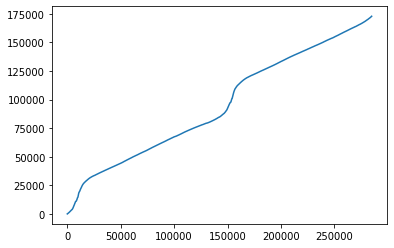

In [5]:
df.Time.plot();

Pandas also has a handy `describe()` method that applies some basic statiscal analysis on a dataframe.

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


If we scroll to the right, we see that the `max(Class)` is 1, `min(Class)` is 0 and no other values (see 25%, 50% and 75% quadrants) seem present. Let's confirm that with the histogram of `Class`. Recall, the trailing `;` suppresses textual output.

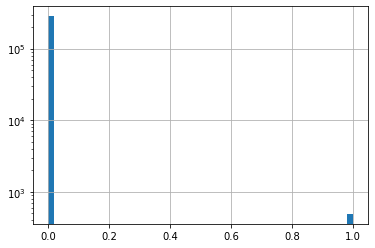

In [7]:
df["Class"].hist(bins=50, log=True);

I plotted the histogram using log y-axis, because the count of 1's is small compared to the count of 0's. How small?

In [8]:
df["Class"].sum()

492

This means that 492 transactions were fraudulent (of a quarter of a million).

I wanted to be absolutely sure that 0 and 1 are the only values occuring in `Class`. I did not know any other solution than simply looping...

In [9]:
c0 = 0
c1 = 0
cx = 0
for v in df["Class"]:
    if v==0 : c0+=1
    elif v==1 : c1+=1
    else : cx+=1
print( f"#0={c0}, #1={c1}, #rest={cx}, #all={c0+c1+cx}")

#0=284315, #1=492, #rest=0, #all=284807


## Preparing the credit card data for training

We follow the naming convention for machine learning that `x` are the input records, and `y` is the (expected) output for each record. We copy the data from pandas to numpy, splitting off the `Class` ("output") column to `y`, all other ("input") columns will go to `x`.

For some reason `to_numpy()` picks `int` as datatype for the Class column, and machine learning wants floats, so we perform an explicit cast. We check the `y` slice 500-600; there is one fraudulent transaction (second row, 8th number).

In [10]:
y = df['Class'].to_numpy().astype(np.float32)
y[500:600]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

To get the remaining columns in `x` we use the `drop` method. Here the `to_numpy()` returns `numpy.float64`, and again we want `float32`. We check record 0; the print out has 4 colums of 7 plus 2 numbers; that is 30 numbers. So indeed we dropped one. The last column of `x[0]` is `1.4962e+02`, or 149.62; this is the "amount" which we also found in our very first table `df.head()`.

In [11]:
x = df.drop(columns='Class').to_numpy().astype(np.float32)
x[0]

array([ 0.0000000e+00, -1.3598071e+00, -7.2781175e-02,  2.5363467e+00,
        1.3781552e+00, -3.3832076e-01,  4.6238777e-01,  2.3959856e-01,
        9.8697901e-02,  3.6378697e-01,  9.0794168e-02, -5.5159956e-01,
       -6.1780083e-01, -9.9138987e-01, -3.1116936e-01,  1.4681770e+00,
       -4.7040051e-01,  2.0797125e-01,  2.5790580e-02,  4.0399295e-01,
        2.5141209e-01, -1.8306779e-02,  2.7783757e-01, -1.1047391e-01,
        6.6928074e-02,  1.2853935e-01, -1.8911484e-01,  1.3355838e-01,
       -2.1053053e-02,  1.4962000e+02], dtype=float32)

It seems it is good practice to _normalize_ the data, and John uses `RobustScaler().fit_transform(x)` for that. I guess this redistributes the values of each column to be in a manageable range since ML training likes that. Let us plot the histogram of column 0 (using the slice `x[:,0]`) before we do the normalization.

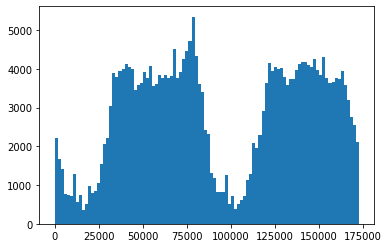

In [12]:
import matplotlib.pyplot as plt
plt.hist(x[:,0], bins=100);


Let us then normalize and plot column 0 again. We see that the shape is retained, but the x-values have been normalized to -1 .. +1. See [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) details on the scaler.

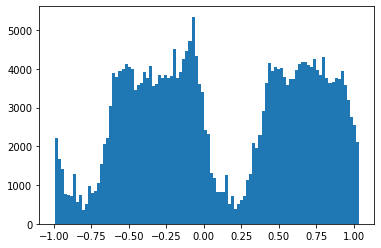

In [13]:
from sklearn.preprocessing import RobustScaler
x = RobustScaler().fit_transform(x)
plt.hist(x[:,0], bins=100);

# Splitting data for train and test

Next step is to split the available records in records for _training_ and records for _testing_ (needed after training is completed). of course, the splitting needs to keep the x-records (inputs) together with the y-records (output). 

There is an easy function for that in `sklearn` package: `train_test_split`. However, this function shuffles the data, which means that each run of this notebook, the (training) outcome is different. I don't want that. 


In [14]:
from sklearn.model_selection import train_test_split

To understand which values `train_test_split` takes, I wrote the `plot2` function. It overlays a graph (connected points) of `y1` with the points `y2`. We test it on a simple parabole. Note, `plot2` first sorts the values to plot (so that the "connection" - lines between the points- works).

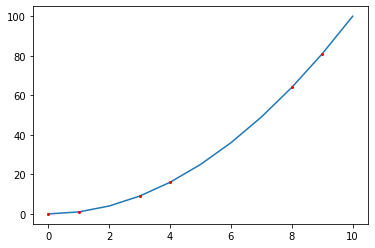

In [15]:
def plot2(y1,y2) :
    y1 = np.sort(y1)
    x1 = range(len(y1))
    y2 = np.sort(y2)
    # y2 is a subset of y1, find the matching x's
    x2 = []
    i1 = 0
    i2 = 0
    while i2<len(y2) :
        while y1[i1]<y2[i2] : i1+=1
        x2.append(x1[i1])
        i2+=1
        i1+=1
    plt.plot(x1,y1)
    plt.plot(x2,y2,c='red' ,marker='o',markersize=2,linewidth=0)

plot2( [0,1,4,9,16,25,36,49,64,81,100] , [0,1,9,16,64,81] )

We now use `plot2()` on the "Time" column to see what `shuffle` means in `train_test_split()`.


[-0.9949835  -0.9949835  -0.99497175 -0.99497175 -0.99496    -0.99496   ]
[-0.9949835  -0.9949835  -0.99497175 -0.99497175 -0.99496    -0.99496   ]


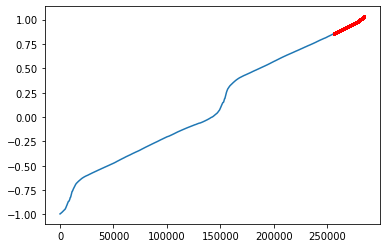

In [16]:
train_x, test_x, train_y, test_y = train_test_split( x, y, test_size=0.1, shuffle=False )
print( x[:6,0] )
print( train_x[:6,0] )
plot2( x[:,0], test_x[:,0] )

For the shufflied case, we need to reduce `test_size` because with value 0.1 the second graph is still completely red due to the enormous amount of points. We pass an explicit `shuffle=True`, but that is not necesary, because that is the default anuhow.

[-0.9949835  -0.9949835  -0.99497175 -0.99497175 -0.99496    -0.99496   ]
[-0.04610017 -0.4983611   0.12652874  0.66921604 -0.47823635 -0.13505797]


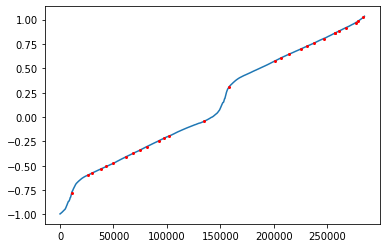

In [17]:
train_x, test_x, train_y, test_y = train_test_split( x, y, test_size=0.0001, shuffle=True )
print( x[:6,0] )
print( train_x[:6,0] )
plot2( x[:,0], test_x[:,0] )

What we see (first case, `Shuffle=False`) is that the records for test are just take from the end of the data set (first graph). If we use `Shuffle=True`, the data set is first shuffled, and then still, the data is taken from the suffled end. To prevent bias on the "Time" column, it makes sense to shuffle. However, this means that each run of the notebook, the (training) outcome is different. That is not nice for the accompanying documentation.

As it turns out, `train_test_split()` has yet another parameter `random_state` which acts as the seed for the random number generator during shuffling. But in this notebook we have already seeded on global level, so we do not need to supply a seed here.

Now we split the available records in records for _training_ and records for _testing_ after training is completed. We split of 10% for testing (`test_size`) with shuffle (since `shuffle=True` is the default). 

In [18]:
train_x, test_x, train_y, test_y = train_test_split( x, y, test_size=0.1 )
print("total  train  test  sum    test/total")
print(len(df), len(train_x), len(test_x), len(train_x)+len(test_x), len(test_x)/len(df))

total  train  test  sum    test/total
284807 256326 28481 284807 0.10000105334489671


## Recap on neural networks

Let us quickly review what a neural network consists of.

A neural net consists of neurons. A _neuron_ maps multiple input values to one output value.

![One neuron](nn-1neuron.png)

A neuron consists of two computation. The first computation linearly combines the inputs. This is simply a weighted sum of the inputs incremented with a bias. The weights and bias are specific to the neuron; they will be established by training. The second computation is an [activation function](https://en.wikipedia.org/wiki/Activation_function). Popular ones are ReLU and Sigmoid. The activation function establishes a threshold that _activates_ the neuron (gives the output a high value), once the weighted average and bias exceed the threshold (which is hard-wired in the activation function).

Observe that the neuron in the picture has 4 weights (since it has 4 inputs) and 1 bias.

In practice there are multiple neurons running in parallel. This is known as a _layer_. The diagram below shows a layer with 4 inputs (blue) and 3 outputs (red). The number of parameters to be determined by learning grows with a factor of 3: there are now 3 times 4 weights and 1 bias.

![One layer](nn-1layer.png)

There is another factor causing grows: in practice there are multiple layers in sequence forming a _neural network_. The diagram below shows two layers (green). Now there are 3×4 weights and 3×1 biases plus 2×3 weights and 2×1 biases.

![One network](nn-1net.png)

Let us now go back to the neural network for the credit card fraude. John designed a network with two layers. The first layer uses all 30 inputs, and generates 8 outputs. These are sometimes called _features_; they are supposed to characterize some higher level aspect of the inputs. What those features are is not designed; they emerge from the training.

The second layer maps the 8 features to one output; the prediction for `Class`.

![Neural net for credit card](nn-creditcard.png)

I wonder, whether the _computations_ make the layers (as in the figure above), or the _storage of the values_ make the layers (as in the figure below). It doesn't matter much, but many people, including John refer to this network as having three layers, so apparently they count "storage".

![Neural net for credit card (alternative view)](nn-creditcard-alt.png)

## Setting up the neural network

We use Tensorflow

> TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications.

We use Keras, the high level API of Tensorflow

> Keras is an API designed for human beings, not machines. 
> Keras is an open-source software library that provides a Python interface for artificial neural networks. Keras acts as an interface for the TensorFlow library. 

Our first step is to create an (empty) neural network model. `Sequential` indicates that we have a network where the layers are sequential.

In [19]:
import tensorflow as tf
model = tf.keras.models.Sequential()

First we add a `Dense` layer. A dense layer computes a weighted sum of _all_ of the values in the previous layer. The layer has 8 neurons (`units` argument), and thus 8 outputs. It uses all 30 inputs (`input_shape`). After the weighted sum, we use a ReLU as activation function. By the way, the funny notation `(30,)` is the Python notation for a tuple of one (the fragment `(30)` would be an expression consisting of the literal `30` and superflous parenthesis around it).

In [20]:
model.add( tf.keras.layers.Dense( units=8, activation='relu', input_shape=(30,) ) )

Next we add a second `Dense` layer, with one neuron (one output). I guess that we do not have to specify `input_shape` because by default a layer takes all outputs of the previous layer. In step one, there was no previous layer; we did not yet specify the inputs. The activation function is now a sigmoid, that gives a value between 0 and 1.

In [21]:
model.add( tf.keras.layers.Dense( units=1, activation='sigmoid' ) )

Finally, we need to "compile" the model.
The _Binary Cross Entropy_ is a good loss function (also known as "cost function") for classification into two classes.
_Adam_ is a stochastic gradient descent optimizer.
We request two extra metrics to be computed: _accuracy_ and _recall_.

In [22]:
model.compile( loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy', tf.keras.metrics.Recall()] )

Once we have compiled the model we can ask for a summary.

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 248       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


Note that the number of parameters matches what we computed in the "Recap" section.
For the first layer 30×8 weights plus 8 biases, so 248 parameters.
For the second 8×1 weights plus 1 bias or 9 parameters.
A total of 257 trainable parameters.

## Training the neural network

We are ready to train: we fit the trainable parameters to the input data (`train_x` and `train_y`). The training ("fitting") requires setting the number of training iterations.

From the [keras documentation](https://keras.io/api/models/model_training_apis/)

> **epochs**: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided.  
> **batch_size**: Integer or None. Number of samples per gradient update. 


As it turns out, _fitting_ the model is also a stochastic process (as was `train_test_split()`).
This means that `model.fit()` uses randomness, e.g. to initialize the weights and biases.
As a result, every training sessions - each run of `model.fit()` - the results vary.

For this notebook, I circumvented that by seeding the random number generator (see first code cell of this notebook).

In [24]:
model.fit( train_x, train_y, epochs=20, batch_size=1024 );

Epoch 1/20
251/251 [==============================] - 1s 538us/step - loss: 0.3271 - accuracy: 0.9397 - recall: 0.0089
Epoch 2/20
251/251 [==============================] - 0s 562us/step - loss: 0.0794 - accuracy: 0.9982 - recall: 0.0000e+00
Epoch 3/20
251/251 [==============================] - 0s 551us/step - loss: 0.0317 - accuracy: 0.9982 - recall: 0.0000e+00
Epoch 4/20
251/251 [==============================] - 0s 552us/step - loss: 0.0180 - accuracy: 0.9983 - recall: 0.0000e+00
Epoch 5/20
251/251 [==============================] - 0s 531us/step - loss: 0.0123 - accuracy: 0.9983 - recall: 0.0000e+00
Epoch 6/20
251/251 [==============================] - 0s 538us/step - loss: 0.0096 - accuracy: 0.9983 - recall: 0.0000e+00
Epoch 7/20
251/251 [==============================] - 0s 536us/step - loss: 0.0080 - accuracy: 0.9983 - recall: 0.0000e+00
Epoch 8/20
251/251 [==============================] - 0s 541us/step - loss: 0.0070 - accuracy: 0.9983 - recall: 0.0000e+00
Epoch 9/20
251/251 [

With `timeit` we check the computation time; on my PC only 2.39 seconds.

The last log line gives the loss, accuracy and recall, just as we specified in the compile step.

The accuracy looks very good: 0.999x, but this is very misleading. Accuracy indicates the number of transactions classified correctly. Remember that we have 492 fradulent transaction in a volume of 284807 transactions. So, a model that predicts that all transactions are valid (model always outputs 0) already has an accuracy of 1 - 492/284807 = 0.9983.

In [25]:
1 - 492/284807

0.9982725143693799

That's why we added the metric _recall_. Recall indicates the number of fraudulent transactions that are classified correctly. We achieved a recall of about 80%.

## Testing the neural network

Final step is to test the network on the test data.

In [26]:
loss, accuracy, recall = model.evaluate( test_x, test_y)
print( f"{loss=:.4f} {accuracy=:.4f} {recall=:.4f}" )

891/891 [==============================] - 0s 361us/step - loss: 0.0028 - accuracy: 0.9996 - recall: 0.8409
loss=0.0028 accuracy=0.9996 recall=0.8409


The accuracy roughly stays the same, and recall goes a bit up. But all in all, similar result as for training. That is good. It means our model is not biased towards to training data ("overfit").

## An alternative network

Just out of curiosity, what happens if we change the network. Let's give the first layer less neurons (5 instead of 8), but let's insert another dense layer of 3 neurons.

In [27]:
model2 = tf.keras.models.Sequential()
model2.add( tf.keras.layers.Dense( units=5, activation='relu', input_shape=(30,) ) )
model2.add( tf.keras.layers.Dense( units=3, activation='relu' ) )
model2.add( tf.keras.layers.Dense( units=1, activation='sigmoid' ) )
model2.compile( loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy', tf.keras.metrics.Recall()] )
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 155       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


Note that we now have to fit much less parameters: 177 instead of 257. We need more epochs though.

In [28]:
model2.fit( train_x, train_y, epochs=50, batch_size=1024 );

Epoch 1/50
251/251 [==============================] - 1s 655us/step - loss: 0.3445 - accuracy: 0.9807 - recall_1: 0.0000e+00
Epoch 2/50
251/251 [==============================] - 0s 647us/step - loss: 0.0607 - accuracy: 0.9983 - recall_1: 0.0000e+00
Epoch 3/50
251/251 [==============================] - 0s 659us/step - loss: 0.0211 - accuracy: 0.9983 - recall_1: 0.0000e+00
Epoch 4/50
251/251 [==============================] - 0s 675us/step - loss: 0.0127 - accuracy: 0.9983 - recall_1: 0.0000e+00
Epoch 5/50
251/251 [==============================] - 0s 648us/step - loss: 0.0096 - accuracy: 0.9983 - recall_1: 0.0000e+00
Epoch 6/50
251/251 [==============================] - 0s 649us/step - loss: 0.0081 - accuracy: 0.9983 - recall_1: 0.0000e+00
Epoch 7/50
251/251 [==============================] - 0s 651us/step - loss: 0.0071 - accuracy: 0.9983 - recall_1: 0.0000e+00
Epoch 8/50
251/251 [==============================] - 0s 646us/step - loss: 0.0064 - accuracy: 0.9983 - recall_1: 0.0000e+00


After about 40 epoch, the recall starts to reach the old level of about 80%.

Let's test.

In [29]:
loss, accuracy, recall = model2.evaluate( test_x, test_y)
print( f"{loss=:.4f} {accuracy=:.4f} {recall=:.4f}" )

891/891 [==============================] - 0s 380us/step - loss: 0.0026 - accuracy: 0.9996 - recall_1: 0.8409
loss=0.0026 accuracy=0.9996 recall=0.8409


That is a bit surprising. We have less parameters, same results. 
Also surprising: we need more training though we have less parameters.

(end of doc)